In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/protein_data.csv')
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(
    data,
    stratify=data['classification'],
    # train_size=10_000,
    train_size=20_000,
    random_state=42
)
df_sampled.head()

,sequence,classification
71573,XEWEALEKKLAALESKXQALEKKLEALEHGX,DE NOVO PROTEIN
257713,GPGSMSIPTLNPTVALVAIDLQNGIVVLPMVPQSGGDVVAKTAELA...,UNKNOWN FUNCTION
169619,ALLSFERKYRVPGGTLVGGNLFDFWVGPFYVGFFGVATFFFAALGI...,PHOTOSYNTHESIS
13661,MGHHHHHHSGEDEQQEQTIAEDLVVTKYKMGGDIANRVLRSLVEAS...,TRANSCRIPTION
60685,XFMAFWEXLX,CELL CYCLE


In [3]:
len(df_sampled)

20000

In [4]:
df_sampled['classification'].value_counts()

classification
DE NOVO PROTEIN                            625
UNKNOWN FUNCTION                           625
SIGNALING PROTEIN                          625
IMMUNE SYSTEM                              625
STRUCTURAL GENOMICS, UNKNOWN FUNCTION      625
OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR    625
CHAPERONE                                  625
HYDROLASE                                  625
LIGASE                                     625
TRANSFERASE                                625
GENE REGULATION                            625
TRANSFERASE/TRANSFERASE INHIBITOR          625
RNA BINDING PROTEIN                        625
STRUCTURAL PROTEIN                         625
PROTEIN TRANSPORT                          625
CELL ADHESION                              625
OXIDOREDUCTASE                             625
PROTEIN BINDING                            625
TRANSPORT PROTEIN                          625
TOXIN                                      625
DNA BINDING PROTEIN                        62

In [5]:
X = df_sampled['sequence']
y = df_sampled['classification']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [6]:
avg_char_len = X_train.str.len().mean()
print(f"Average character length: {avg_char_len:.2f}")

Average character length: 241.07


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

def preprocess_sequence(sequence):
    return ' '.join(list(sequence.strip()))

def tokenize_sequences(sequences, max_length=250):
    sequences = [preprocess_sequence(seq) for seq in sequences]
    return tokenizer(
        sequences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, max_length=250):
        self.labels = labels
        tokenized = tokenize_sequences(sequences, max_length=max_length)
        self.input_ids = tokenized["input_ids"]
        self.attention_mask = tokenized["attention_mask"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ProteinDataset(X_train.tolist(), y_train.tolist())
val_dataset = ProteinDataset(X_val.tolist(), y_val.tolist())
test_dataset = ProteinDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:
import torch.nn as nn
from transformers import BertModel

class ProteinClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained("Rostlab/prot_bert")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)


In [10]:
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience=3, delta=0, path="checkpoint.pt", verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change in monitored metric to qualify as improvement.
            path (str): File path to save the best model.
            verbose (bool): Print messages when improvement happens.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # tensor of class weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# suppose y_train contains your training labels (numpy array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [16]:
import time
from sklearn.metrics import accuracy_score
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinClassifier(num_labels=n_classes).to(device)

# Freeze BERT encoder
# for param in model.bert.parameters():
#     param.requires_grad = False
for name, param in model.bert.named_parameters():
    if "encoder.layer.28" in name or "encoder.layer.29" in name or "encoder.layer.30" in name or "encoder.layer.31" in name:
        param.requires_grad = True   # unfreeze last 4 layers
    else:
        param.requires_grad = False

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 2e-5},        # pretrained encoder (small LR)
    {"params": model.classifier.parameters(), "lr": 1e-4},  # classifier head (larger LR)
], weight_decay=0.01)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(gamma=2, alpha=class_weights)

EPOCHS = 20

# History dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

early_stopping = EarlyStopping(patience=5, verbose=True, path="./models/probert_focal_loss.pt")

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_train_labels, all_train_preds)

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {elapsed:.2f}s")

    # Save to history
    history['train_loss'].append(total_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_time'].append(elapsed)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch 1/20 | Train Loss: 1364.3749 | Train Acc: 0.0551 | Val Loss: 140.6246 | Val Acc: 0.0750 | Time: 525.66s
Validation loss decreased (inf → 140.624592). Saving model...
Epoch 2/20 | Train Loss: 1235.2639 | Train Acc: 0.0694 | Val Loss: 133.9388 | Val Acc: 0.0788 | Time: 524.73s
Validation loss decreased (140.624592 → 133.938817). Saving model...
Epoch 3/20 | Train Loss: 1180.4848 | Train Acc: 0.0782 | Val Loss: 129.6403 | Val Acc: 0.1037 | Time: 524.37s
Validation loss decreased (133.938817 → 129.640255). Saving model...
Epoch 4/20 | Train Loss: 1110.5022 | Train Acc: 0.1086 | Val Loss: 121.3207 | Val Acc: 0.1550 | Time: 525.25s
Validation loss decreased (129.640255 → 121.320712). Saving model...
Epoch 5/20 | Train Loss: 1007.1302 | Train Acc: 0.1447 | Val Loss: 114.6597 | Val Acc: 0.1644 | Time: 524.43s
Validation loss decreased (121.320712 → 114.659695). Saving model...
Epoch 6/20 | Train Loss: 916.6002 | Train Acc: 0.1810 | Val Loss: 111.4386 | Val Acc: 0.2013 | Time: 524.51s
Val

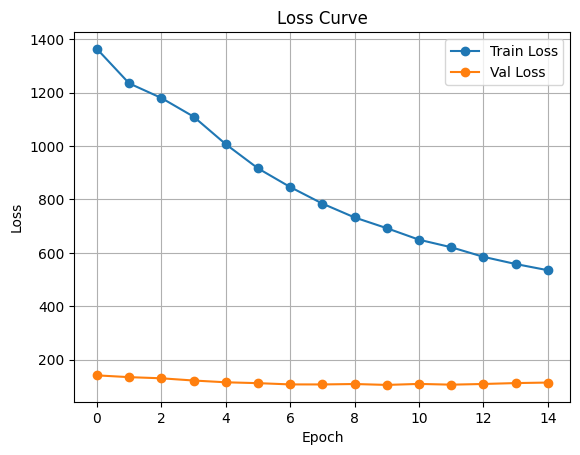

In [17]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

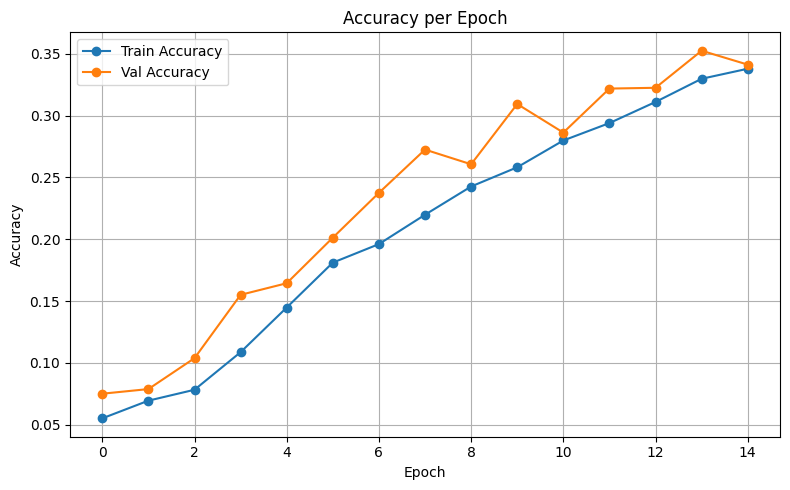

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
test_loader = DataLoader(test_dataset, batch_size=8)

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average="weighted")
recall = recall_score(test_labels, test_preds, average="weighted")
f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.3167
Precision: 0.2598
Recall: 0.3167
F1 Score: 0.2637


C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.57      0.18      0.27       119
           1       0.28      0.49      0.36       128
           2       0.28      0.56      0.37       127
           3       0.34      0.72      0.46       119
           4       0.23      0.30      0.26       132
           5       0.34      0.09      0.14       123
           6       0.33      0.70      0.44       133
           7       0.00      0.00      0.00       120
           8       0.27      0.32      0.29       147
           9       0.00      0.00      0.00       123
          10       0.66      0.29      0.41       140
          11       0.29      0.45      0.36       111
          12       0.37      0.56      0.45       104
          13       0.26      0.30      0.28       127
          14       0.37      0.25      0.30       128
          15       0.44      0.35      0.39       132
          16       0.72      0.85      0.78       123
          17       0.51    

C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


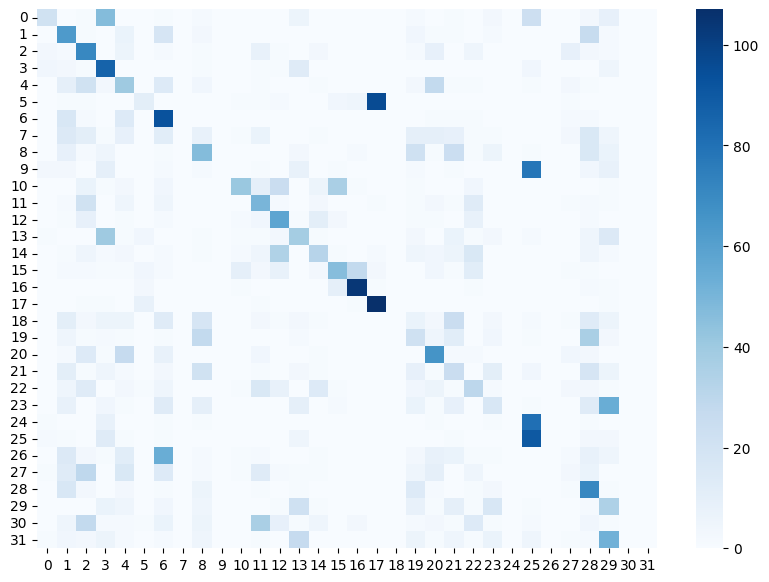

In [22]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap='Blues');